In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import pylab as pl

# 1. Finding Similar Costumers

## 1.1 Set up the data

In [120]:
data=pd.read_csv('/Users/the_redd_/Desktop/ADM/HW4/bank_transactions.csv')

In [121]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

## Examining the content of the dataset

### Setting dtype up

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


As we can see, *CustomerDOB*, *TransactionDate* and *TransactionTime* are object in this dataframe, let's handle it. 

In [123]:
#Let's convert TransactionDate to datetime, in order to get a date
data.TransactionDate = pd.to_datetime(data.TransactionDate) 

#Let's convert TransactionTime to datetime, in order to get the time 
def convert_time(value):
    sec = value % 100
    minutes = (value//100)%100
    hours = (value//10000)%100
    date = str(hours)+":"+str(minutes)+":"+str(sec)
    datetime_object = datetime.strptime(date,'%H:%M:%S').time()
    return datetime_object

#Let's apply the function
data['TransactionTime']=data.TransactionTime.apply(lambda row: convert_time(row))

# dt.normalize() basically sets all time component to 00:00:00, and it will only 
# display the date while keeping the datetime64 data format, thereby making it possible to do calculations with it.

data['TransactionTime']=pd.to_datetime(data['TransactionTime'], format='%H:%M:%S') - pd.to_datetime(data['TransactionTime'], format='%H:%M:%S').dt.normalize()

Text(0, 0.5, 'Number of customers')

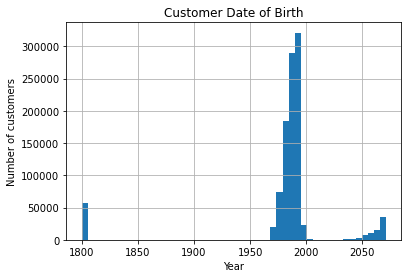

In [124]:
#Now let's handle CustomerDOB
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) # fix date of birth

#Then let's visualize our data
data.CustomerDOB.dt.year.hist(bins=50)
pl.title("Customer Date of Birth")
pl.xlabel("Year")
pl.ylabel("Number of customers")


Text(0, 0.5, 'Number of customers')

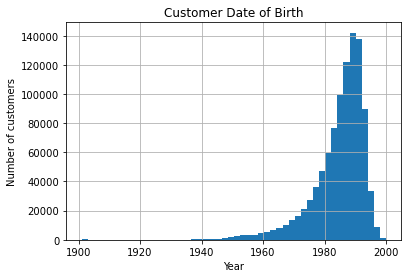

In [125]:
#There are some problems here, since the dataset is from 2016, we suppose valid only date of birth before 2000 and
# possibly, after 1900.

# Let's subtract 100 years to customers whose dob is above 2000
data.loc[data.CustomerDOB.dt.year >2000, 'CustomerDOB'] =  data.loc[data.CustomerDOB.dt.year >2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

# Then let's drop data from customers whose dob is 1800
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0,inplace=True) 

#Let's visualize the result
data.CustomerDOB.dt.year.hist(bins=50) # there are problems with the DOB
pl.title("Customer Date of Birth")
pl.xlabel("Year")
pl.ylabel("Number of customers")

In [128]:
#Let's use the CustomerDOB in order to create a new feature, the age of costumer
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

#Now let's drop all Nan so we can convert into integers
data.dropna(subset=['CustomerAge'],inplace=True)

#Then we convert them
data['CustomerAge'] = data['CustomerAge'].astype(int)

In [130]:
# Perfect, now we have all the dtype ready to be used
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987831 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   TransactionID            987831 non-null  object         
 1   CustomerID               987831 non-null  object         
 2   CustomerDOB              987831 non-null  datetime64[ns] 
 3   CustGender               987667 non-null  object         
 4   CustLocation             987680 non-null  object         
 5   CustAccountBalance       985637 non-null  float64        
 6   TransactionDate          987831 non-null  datetime64[ns] 
 7   TransactionTime          987831 non-null  timedelta64[ns]
 8   TransactionAmount (INR)  987831 non-null  float64        
 9   CustomerAge              987831 non-null  int64          
dtypes: datetime64[ns](2), float64(2), int64(1), object(4), timedelta64[ns](1)
memory usage: 82.9+ MB


### Dealing with NAN values

In [133]:
#Let's see if there are any Nan in the dataset
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                   0
CustGender                  164
CustLocation                151
CustAccountBalance         2194
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
CustomerAge                   0
dtype: int64

In [134]:
for col in data.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(data[col].isna().sum()/len(data)*100,2)) + '%')

Percentage of null values of TransactionID: 0.0%
Percentage of null values of CustomerID: 0.0%
Percentage of null values of CustomerDOB: 0.0%
Percentage of null values of CustGender: 0.02%
Percentage of null values of CustLocation: 0.02%
Percentage of null values of CustAccountBalance: 0.22%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of CustomerAge: 0.0%


In [137]:
# Since the percentage of Nan values in CustGender and CustLocation is smaller than 0.03%, we decide to drop them.

data.dropna(subset=['CustGender','CustLocation'], inplace = True)

#Taking into account CustAccountBalance, we can fill all the Nan values with the mean computed for every location and drop all the Nan values with no location

data.CustAccountBalance = data.CustAccountBalance.fillna(data.groupby('CustLocation')['CustAccountBalance'].transform('mean'))

data.dropna(subset=['CustAccountBalance'], inplace = True)

In [138]:
data.isnull().sum() #Better

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
CustomerAge                0
dtype: int64

### Checking columns

In [141]:
#Let's drop TransactionID since it is quite useless in our analysis
data.drop(['TransactionID'],axis=1,inplace=True)

In [143]:
#Then let's check CustGender
data['CustGender'].value_counts()

M    713861
F    273497
Name: CustGender, dtype: int64

In [146]:
#Let's rename TransactionAmount (INR) in TransactionAmount just for semplicity
data.rename(columns={'TransactionAmount (INR)':'TransactionAmount'},inplace=True)
data.head(1)

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,CustomerAge
0,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,0 days 14:32:07,25.0,28


## Exploratory Data Analysis(EDA)